# 🧪 Lab: Modelling & Model Lifecycle — Predicting Plant Production (GIST Steel Dataset)

---

## 🎯 Learning Outcomes

By completing this lab, you will be able to:

- Prepare and analyse a dataset for modelling.  
- Train and evaluate regression models.  
- Apply cross-validation and hyperparameter tuning using scikit-learn.  
- Track experiments and store models using MLflow and/or Optuna.  
- Reflect on the practical aspects of managing the ML lifecycle.

---



## 🧩 1. Data Setup and Exploration
⏱ *Estimated time: 30–40 min*

### 🧭 Objective  
Understand the dataset structure and the target variable (“plant-level production”).

---

### **Task 1.1 – Load and Inspect Data**
- Load the GIST Steel dataset. 
- Display basic info (shape, column names, missing values, and data types).  
- Identify the target variable (production) and key features (capacity, ...).


In [419]:
import pandas as pd

excel_path = '/Users/philippevannson/Desktop/research_emerging_topics/aidams-materials/Plant-level-data-Global-Iron-and-Steel-Tracker-September-2025-V1.xlsx'   

plant_data = pd.read_excel(excel_path, sheet_name='Plant data')
plant_capacity_and_status = pd.read_excel(excel_path, sheet_name='Plant capacities and status')
plant_production = pd.read_excel(excel_path, sheet_name='Plant production')

plant_capacity_and_status = plant_capacity_and_status[
    plant_capacity_and_status['Status'] == 'operating'
]

plant_production = plant_production[
    plant_production['Type of production'] == 'Crude steel production (ttpa)'
]

valid_plant_ids = plant_production['Plant ID'].unique()
plant_data = plant_data[plant_data['Plant ID'].isin(valid_plant_ids)]

full_data = pd.merge(plant_data, plant_capacity_and_status.drop(columns=['Plant name (English)', 'Plant name (other language)', 'Country/Area', 'Start date']), how='left', on='Plant ID')
full_data = pd.merge(full_data, plant_production.drop(columns=['Plant name (English)']), how='left', on='Plant ID')

###  Data Cleaning Rationale

After concatenating the datasets, I removed unnecessary columns to simplify the model and reduce noise:

* **Plant names** were dropped since names have no predictive power and are purely string identifiers.
* **Owner-related columns** were removed because the **Parent** entity is the one controlling the plant.
* I kept only the **Parent column**, as `Parent GEM ID` and `Parent PermID` are simply alternative identifiers for the same entity.
* **Redundant location columns** (e.g., municipality, region, country) were dropped since geographic information is already captured by the **coordinates**.
* The **GEM wiki page** column was removed because it is too difficult to process meaningfully.
* I **kept all construction, start, and planned end dates**, as these temporal variables could influence production capacity and output.


In [420]:
cols_to_drop = [
    'Plant ID', 'Plant name (English)', 'Plant name (other language)',
    'Other plant names (English)', 'Other plant names (other language)',
    'Owner', 'Owner (other language)', 'Owner GEM ID', 'Owner PermID',
    'Parent', 'Parent GEM ID', 'Parent PermID', 'Location address',
    'Municipality', 'Subnational unit (province/state)', 'Country/Area',
    'Region', 'Other language location address', 'Coordinate accuracy',
    'GEM wiki page', 'Construction date', 'Start date',
    'Pre-retirement announcement date', 'Idled date', 'Retired date',
    'Category steel product', 'Steel products','ISO 14001', 'ISO 50001', 'ResponsibleSteel Certification',
    'Power source', 'Iron ore source',
    'Met coal source', 'Announced date', 'Steel sector end users', 'Status', 'SOE Status', 'Coordinates', 'Plant age (years)'
]

full_data.drop(columns=cols_to_drop, inplace=True)

print('full data shape:', full_data.shape)
print('full data columns:', full_data.columns.tolist())
full_data.head()

full data shape: (462, 22)
full data columns: ['Ferronickel capacity (ttpa)', 'Sinter plant capacity (ttpa)', 'Coking plant capacity (ttpa)', 'Pelletizing plant capacity (ttpa)', 'Workforce size', 'Main production equipment', 'Nominal crude steel capacity (ttpa)', 'Nominal BOF steel capacity (ttpa)', 'Nominal EAF steel capacity (ttpa)', 'Nominal OHF steel capacity (ttpa)', 'Other/unspecified steel capacity (ttpa)', 'Nominal iron capacity (ttpa)', 'Nominal BF capacity (ttpa)', 'Nominal DRI capacity (ttpa)', 'Other/unspecified iron capacity (ttpa)', 'Type of production', 2019, 2020, 2021, 2022, 2023, 2024]


,Ferronickel capacity (ttpa),Sinter plant capacity (ttpa),Coking plant capacity (ttpa),Pelletizing plant capacity (ttpa),Workforce size,Main production equipment,Nominal crude steel capacity (ttpa),Nominal BOF steel capacity (ttpa),Nominal EAF steel capacity (ttpa),Nominal OHF steel capacity (ttpa),...,Nominal BF capacity (ttpa),Nominal DRI capacity (ttpa),Other/unspecified iron capacity (ttpa),Type of production,2019,2020,2021,2022,2023,2024
0,unknown,>0,unknown,unknown,5748,BF; BOF; EAF; DRI,2150,350.0,1800,NaN,...,1500,NaN,NaN,Crude steel production (ttpa),unknown,unknown,unknown,unknown,unknown,unknown
1,NaN,unknown,NaN,4000,8000,EAF; DRI,6200,NaN,6200,NaN,...,NaN,5000,NaN,Crude steel production (ttpa),unknown,unknown,unknown,unknown,unknown,unknown
2,NaN,unknown,NaN,unknown,1624,EAF; DRI,2000,NaN,2000,NaN,...,NaN,600,NaN,Crude steel production (ttpa),1100,800,1252,1174,1100,unknown
3,NaN,NaN,NaN,NaN,787,EAF,650,NaN,650,NaN,...,NaN,NaN,NaN,Crude steel production (ttpa),167,182,219,372,356,unknown
4,NaN,unknown,NaN,unknown,2993,EAF; DRI,1720,NaN,1720,NaN,...,NaN,960,NaN,Crude steel production (ttpa),878,694,873,922,910,unknown


In [421]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 462 entries, 0 to 461
Data columns (total 22 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Ferronickel capacity (ttpa)              249 non-null    object 
 1   Sinter plant capacity (ttpa)             282 non-null    object 
 2   Coking plant capacity (ttpa)             258 non-null    object 
 3   Pelletizing plant capacity (ttpa)        276 non-null    object 
 4   Workforce size                           462 non-null    object 
 5   Main production equipment                462 non-null    object 
 6   Nominal crude steel capacity (ttpa)      399 non-null    object 
 7   Nominal BOF steel capacity (ttpa)        170 non-null    float64
 8   Nominal EAF steel capacity (ttpa)        241 non-null    object 
 9   Nominal OHF steel capacity (ttpa)        1 non-null      float64
 10  Other/unspecified steel capacity (ttpa)  25 non-nu

In [422]:
import numpy as np

full_data = full_data.replace("unknown", np.nan)

numeric_cols = [col for col in full_data.columns if col != 'Main production equipment']

full_data[numeric_cols] = full_data[numeric_cols].apply(pd.to_numeric, errors='coerce')

full_data[numeric_cols].describe()

/var/folders/zq/d1p5dt254r9d7_yyy8980f3c0000gn/T/ipykernel_20911/974530075.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  full_data = full_data.replace("unknown", np.nan)


,Ferronickel capacity (ttpa),Sinter plant capacity (ttpa),Coking plant capacity (ttpa),Pelletizing plant capacity (ttpa),Workforce size,Nominal crude steel capacity (ttpa),Nominal BOF steel capacity (ttpa),Nominal EAF steel capacity (ttpa),Nominal OHF steel capacity (ttpa),Other/unspecified steel capacity (ttpa),...,Nominal BF capacity (ttpa),Nominal DRI capacity (ttpa),Other/unspecified iron capacity (ttpa),Type of production,2019,2020,2021,2022,2023,2024
count,11.000000,112.000000,95.000000,52.000000,437.000000,398.000000,170.000000,241.000000,1.0,24.000000,...,194.000000,54.000000,3.000000,0.0,226.000000,265.000000,258.000000,266.000000,267.000000,8.00000
mean,389.454545,4668.223214,1559.484211,2856.634615,4046.661327,3130.773869,5072.647059,1489.958506,2930.0,903.666667,...,4503.907216,1500.203704,2566.666667,NaN,3163.761062,3816.158491,2347.910853,2433.251880,2513.176030,2123.87500
std,1004.937447,3934.385119,1441.064492,3048.825579,5220.833211,3548.136323,4004.577374,1251.565562,NaN,1036.272319,...,3894.339244,1747.210449,1501.110700,NaN,3982.322814,7246.293109,2919.048542,3086.867243,3398.354628,1485.98889
min,0.000000,0.000000,0.000000,0.000000,13.000000,13.000000,334.000000,13.000000,2930.0,92.000000,...,33.000000,9.000000,1700.000000,NaN,88.000000,17.000000,22.000000,11.000000,5.000000,1.00000
25%,0.000000,1495.000000,516.000000,600.000000,720.000000,900.000000,2531.250000,750.000000,2930.0,336.250000,...,1925.000000,376.000000,1700.000000,NaN,673.250000,590.000000,600.000000,600.000000,625.500000,1242.50000
50%,54.000000,4083.000000,1130.000000,1912.500000,2250.000000,1800.000000,3650.000000,1020.000000,2930.0,591.500000,...,3370.000000,980.000000,1700.000000,NaN,1824.000000,1770.000000,1033.500000,1086.500000,1159.000000,2445.00000
75%,235.000000,6782.000000,2109.000000,4003.750000,5489.000000,3700.000000,6420.000000,1720.000000,2930.0,1155.500000,...,6165.000000,1782.500000,3000.000000,NaN,3872.250000,4100.000000,3203.000000,3000.000000,3000.000000,3250.00000
max,3400.000000,18440.000000,6500.000000,12000.000000,35481.000000,22999.000000,22999.000000,10000.000000,2930.0,5000.000000,...,24750.000000,7830.000000,4300.000000,NaN,27000.000000,71819.000000,21643.000000,19343.000000,26627.000000,3830.00000


In [423]:
uninformative_cols = []
treshold = 0.65
for col in full_data.columns.tolist():
    print(f'{col} percentage of NaN is {full_data[col].isna().sum() / full_data.shape[0]:.2%}')
    if (full_data[col].isna().sum() / full_data.shape[0] >= treshold):
        uninformative_cols.append(col)


print('droped uninformative columns:', uninformative_cols)
full_data.drop(columns=uninformative_cols,  inplace=True)

Ferronickel capacity (ttpa) percentage of NaN is 97.62%
Sinter plant capacity (ttpa) percentage of NaN is 75.76%
Coking plant capacity (ttpa) percentage of NaN is 79.44%
Pelletizing plant capacity (ttpa) percentage of NaN is 88.74%
Workforce size percentage of NaN is 5.41%
Main production equipment percentage of NaN is 0.00%
Nominal crude steel capacity (ttpa) percentage of NaN is 13.85%
Nominal BOF steel capacity (ttpa) percentage of NaN is 63.20%
Nominal EAF steel capacity (ttpa) percentage of NaN is 47.84%
Nominal OHF steel capacity (ttpa) percentage of NaN is 99.78%
Other/unspecified steel capacity (ttpa) percentage of NaN is 94.81%
Nominal iron capacity (ttpa) percentage of NaN is 50.87%
Nominal BF capacity (ttpa) percentage of NaN is 58.01%
Nominal DRI capacity (ttpa) percentage of NaN is 88.31%
Other/unspecified iron capacity (ttpa) percentage of NaN is 99.35%
Type of production percentage of NaN is 100.00%
2019 percentage of NaN is 51.08%
2020 percentage of NaN is 42.64%
2021 p

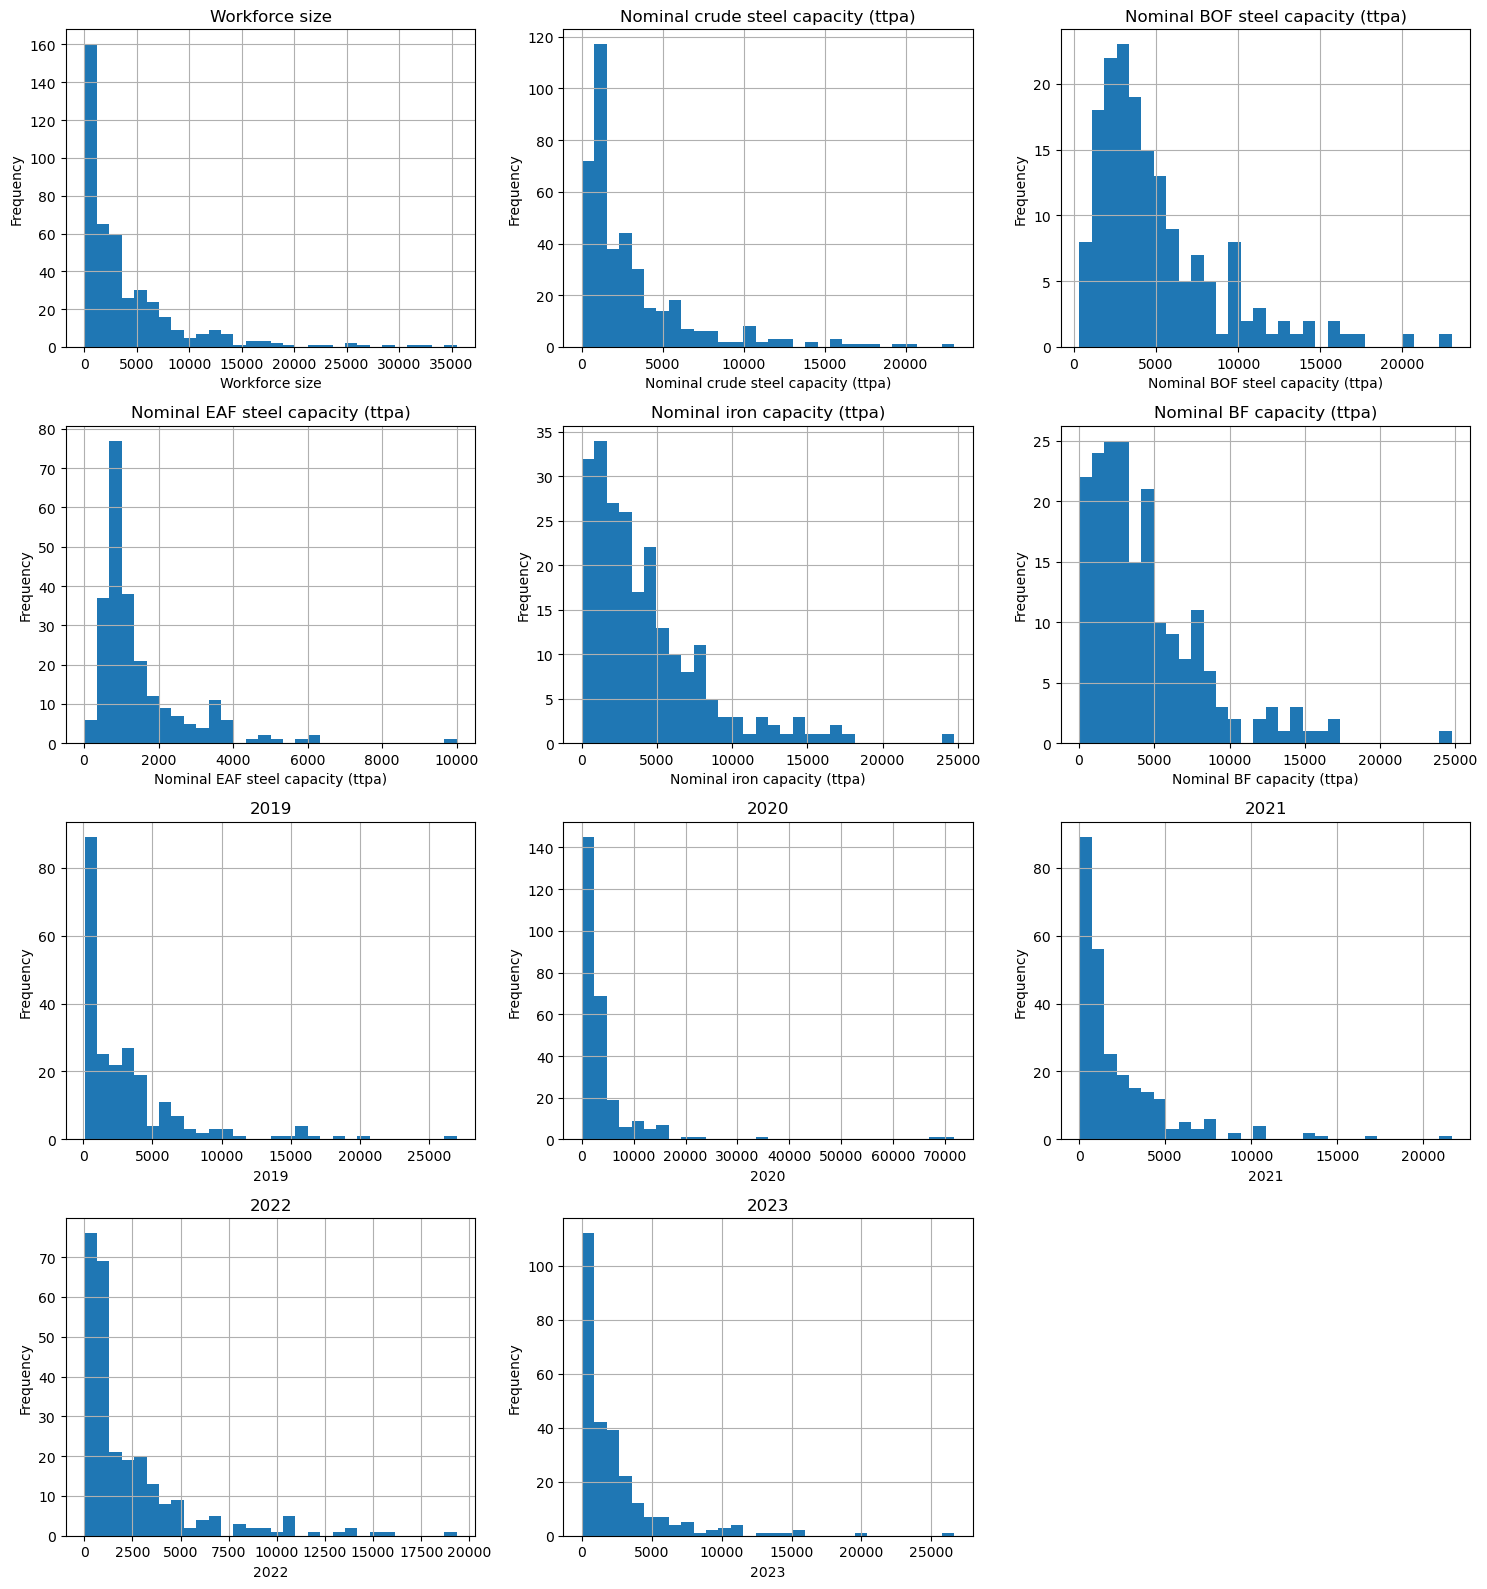

In [424]:

import matplotlib.pyplot as plt

def plot_numeric_histograms(df):
    numeric_cols = df.select_dtypes(include='number').columns
    num_cols = len(numeric_cols)
    ncols = 3
    nrows = (num_cols + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))
    axes = axes.flatten()

    for i, col in enumerate(numeric_cols):
        df[col].hist(ax=axes[i], bins=30)
        axes[i].set_title(str(col))
        axes[i].set_xlabel(str(col))
        axes[i].set_ylabel('Frequency')

    # Hide extra subplots if there are any
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()

plot_numeric_histograms(full_data)


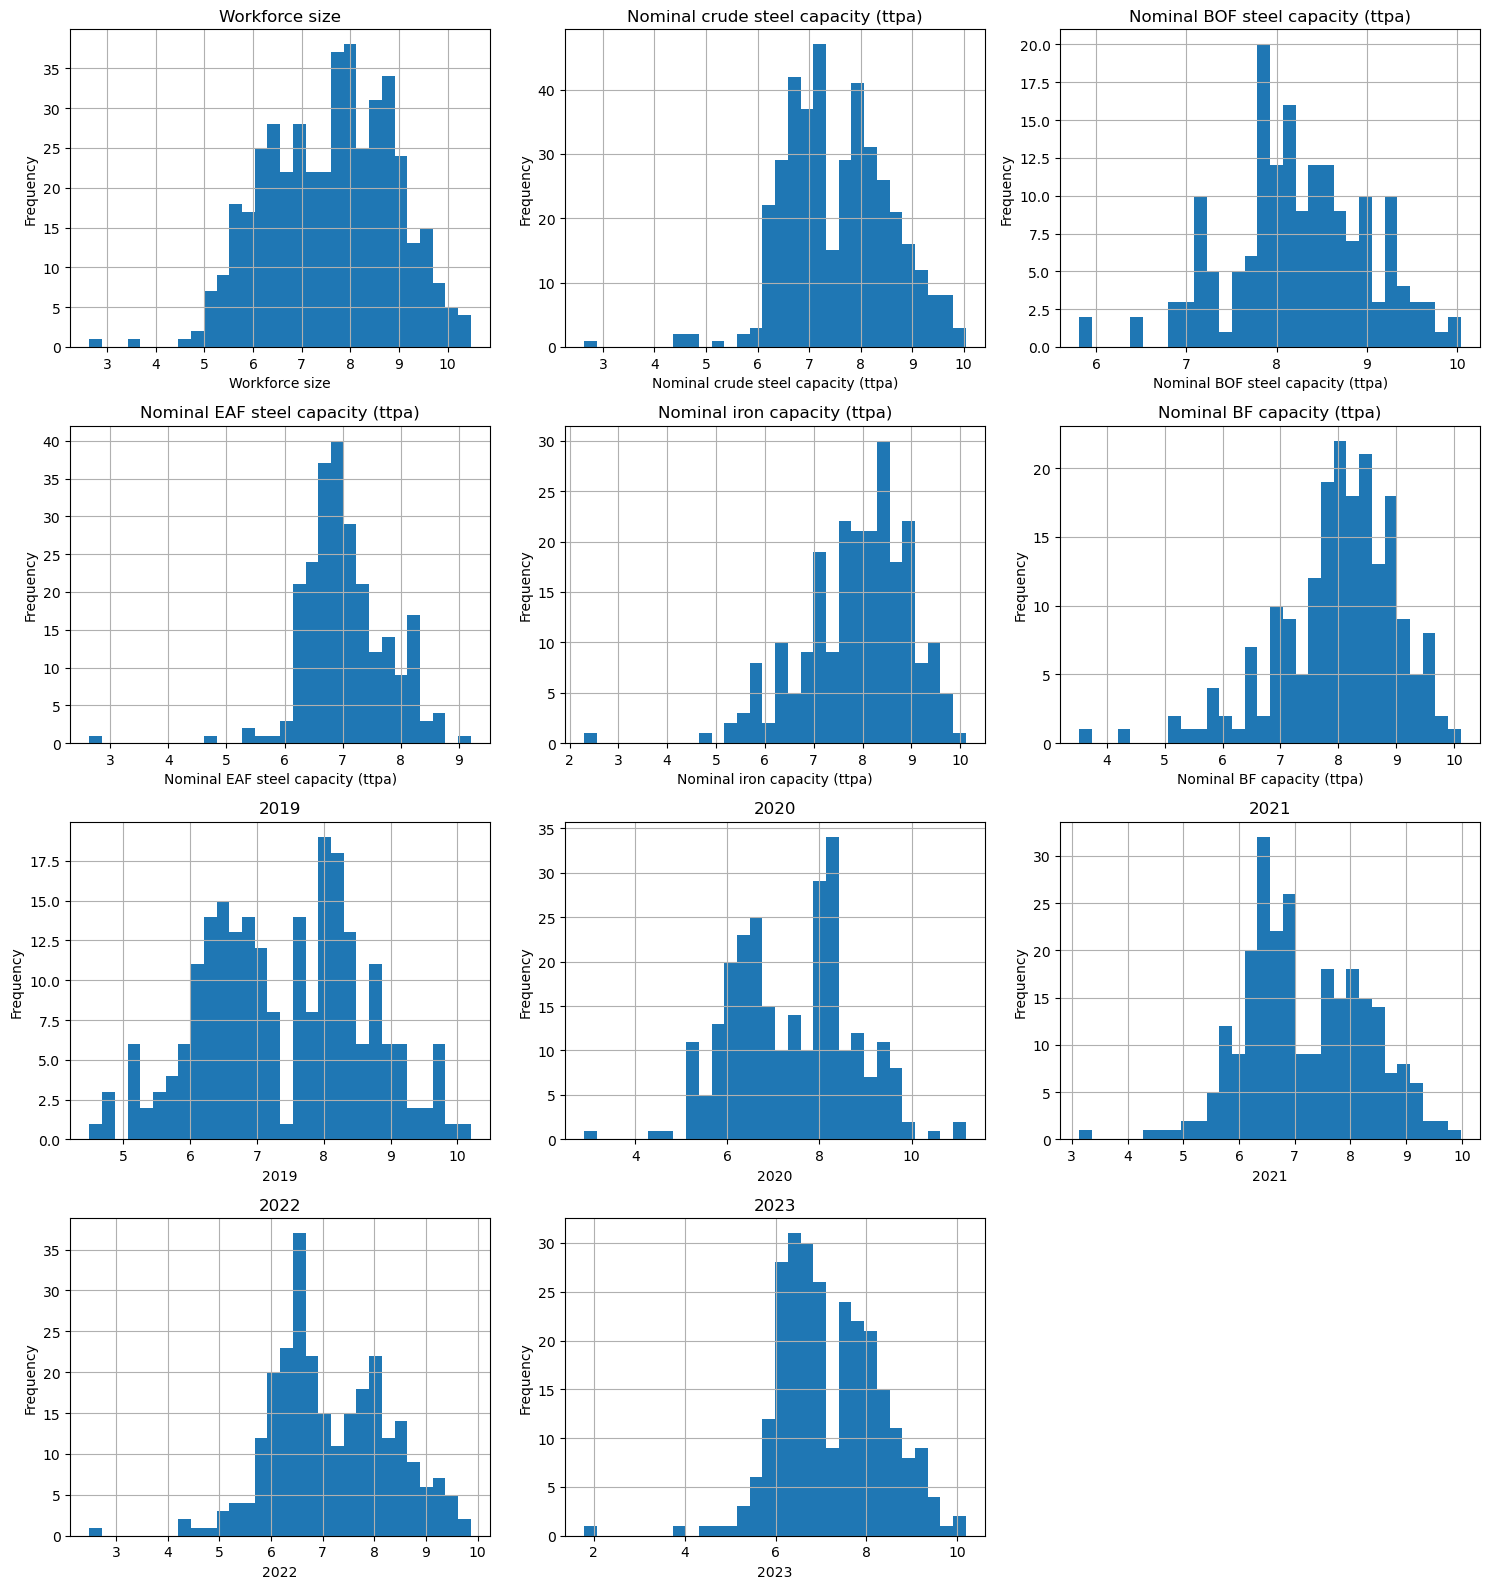

In [425]:
log_transformed_data = full_data.copy()
numeric_cols = log_transformed_data.select_dtypes(include='number').columns
log_transformed_data[numeric_cols] = np.log1p(log_transformed_data[numeric_cols])
plot_numeric_histograms(log_transformed_data)

In [426]:
year_cols = [2019, 2020, 2021, 2022, 2023]

# First, drop rows where ALL year columns are NaN (these can't be imputed meaningfully)
rows_before = len(log_transformed_data)
log_transformed_data = log_transformed_data[~log_transformed_data[year_cols].isna().all(axis=1)].copy()
rows_after = len(log_transformed_data)

print(f"Dropped {rows_before - rows_after} rows with all NaN year values")
print(f"Remaining rows: {rows_after}")

# Now fill the remaining NAs with row means
for idx, row in log_transformed_data.iterrows():
    vals = row[year_cols]
    mean_val = vals.mean(skipna=True)
    if not np.isnan(mean_val):
        log_transformed_data.loc[idx, year_cols] = vals.fillna(mean_val)

# Check NAs in year columns after filling
print(f"\nNAs in year columns AFTER filling:")
print(log_transformed_data[year_cols].isna().sum())

Dropped 28 rows with all NaN year values
Remaining rows: 434


/var/folders/zq/d1p5dt254r9d7_yyy8980f3c0000gn/T/ipykernel_20911/378738738.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  log_transformed_data.loc[idx, year_cols] = vals.fillna(mean_val)
/var/folders/zq/d1p5dt254r9d7_yyy8980f3c0000gn/T/ipykernel_20911/378738738.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  log_transformed_data.loc[idx, year_cols] = vals.fillna(mean_val)
/var/folders/zq/d1p5dt254r9d7_yyy8980f3c0000gn/T/ipykernel_20911/378738738.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and 


NAs in year columns AFTER filling:
2019    0
2020    0
2021    0
2022    0
2023    0
dtype: int64


/var/folders/zq/d1p5dt254r9d7_yyy8980f3c0000gn/T/ipykernel_20911/378738738.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  log_transformed_data.loc[idx, year_cols] = vals.fillna(mean_val)
/var/folders/zq/d1p5dt254r9d7_yyy8980f3c0000gn/T/ipykernel_20911/378738738.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  log_transformed_data.loc[idx, year_cols] = vals.fillna(mean_val)
/var/folders/zq/d1p5dt254r9d7_yyy8980f3c0000gn/T/ipykernel_20911/378738738.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and 

In [427]:
# Median imputation for other numeric columns
columns_to_median_impute = [
    'Workforce size',
    'Nominal crude steel capacity (ttpa)',
    'Nominal BOF steel capacity (ttpa)',
    'Nominal EAF steel capacity (ttpa)',
    'Nominal iron capacity (ttpa)',
    'Nominal BF capacity (ttpa)'
]

# Fill missing values with column medians
for col in columns_to_median_impute:
    if col in log_transformed_data.columns:
        median_val = log_transformed_data[col].median()
        log_transformed_data[col].fillna(median_val, inplace=True)

print("\nNAs AFTER median imputation:")
print(log_transformed_data.isna().sum())



NAs AFTER median imputation:
Workforce size                         0
Main production equipment              0
Nominal crude steel capacity (ttpa)    0
Nominal BOF steel capacity (ttpa)      0
Nominal EAF steel capacity (ttpa)      0
Nominal iron capacity (ttpa)           0
Nominal BF capacity (ttpa)             0
2019                                   0
2020                                   0
2021                                   0
2022                                   0
2023                                   0
dtype: int64


/var/folders/zq/d1p5dt254r9d7_yyy8980f3c0000gn/T/ipykernel_20911/3890498214.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  log_transformed_data[col].fillna(median_val, inplace=True)


We have to scale the variable 



### **Task 1.3 – Feature Engineering**
- Create at least two new variables that might improve model performance (e.g., “capacity per worker”, “energy efficiency”).  
- Encode categorical variables and standardize numeric ones.
- Bonus: you are free to use external socioeconomic or environmental data sources to enhance your feature set.

> 📝 *Markdown prompt:*  
Document your new feature(s). What business or operational insight do they represent?

---


In [428]:
log_transformed_data['capacity_per_worker'] = (
    log_transformed_data['Nominal crude steel capacity (ttpa)'] / log_transformed_data['Workforce size']
)

log_transformed_data['avg_production_per_worker'] = (
    log_transformed_data[[2019, 2020, 2021, 2022, 2023]].mean(axis=1) / 
    log_transformed_data['Workforce size']
)

#log_transformed_data['mean_historic_production'] = log_transformed_data[[2019, 2020, 2021, 2022, 2023]].mean(axis=1)


## 🔍 1.4 Feature Relationships and Correlations
⏱ *Estimated time: 20–25 min*

### 🧭 Objective  
Before training models, it’s essential to understand how features relate to each other and to the target variable — both linearly and nonlinearly. This helps identify redundant or uninformative predictors and guides model choice.

---

### **Task 1.4.1 – Correlation Matrix (Linear Relationships)**
- Compute a **correlation matrix** (e.g., using `df.corr()`, `seaborn.heatmap`, `skrub`) to examine pairwise linear relationships among numerical features.  
- Focus on correlations between each feature and the target (`production`), as well as between features themselves.

> 📝 *Markdown prompt:*  
Which variables show the strongest correlation with production?  
Do any features appear redundant or highly correlated with each other?

---


The most correlated feature is crude steel capacity.
The production years are hyper correlated

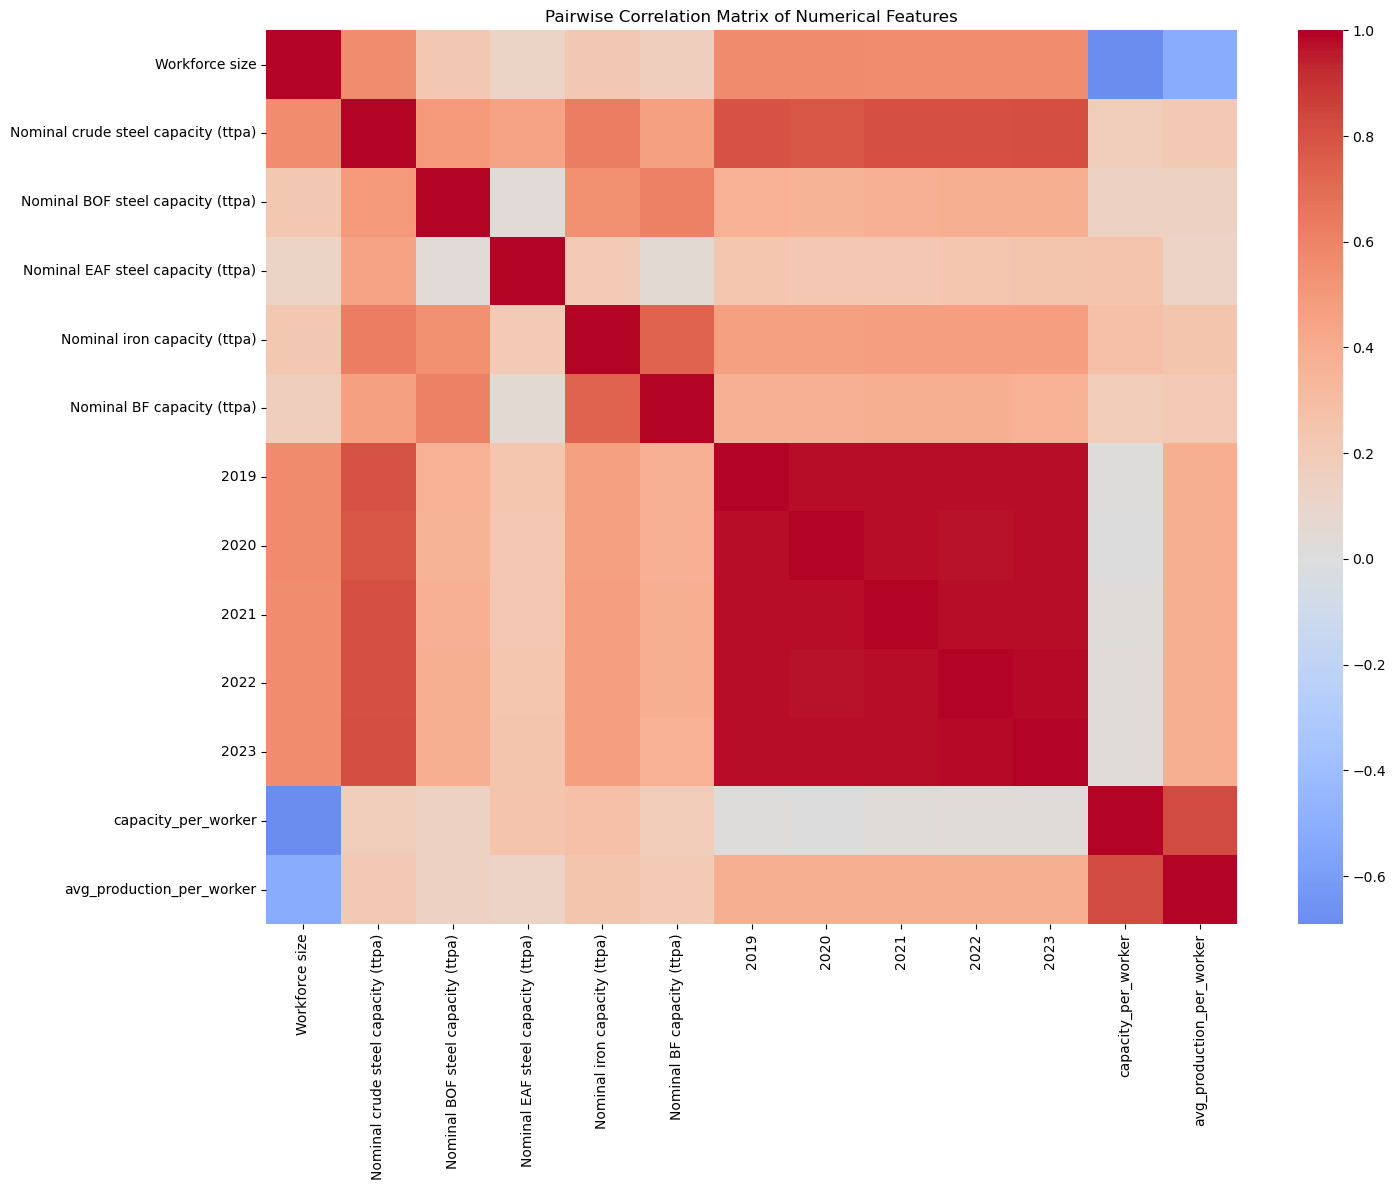

In [429]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select only numerical columns for correlation analysis
numeric_cols = log_transformed_data.select_dtypes(include='number').columns

# Compute correlation matrix
corr_matrix = log_transformed_data[numeric_cols].corr()

# Display the correlation matrix
plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0)
plt.title('Pairwise Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()


## 🧮 2. Building Baseline & Linear Models
⏱ *Estimated time: 25–30 min*

### 🧭 Objective  
Establish a simple baseline, then train and interpret a linear model.

---

### **Task 2.1 – Baseline**
- Compute a simple baseline predictor (e.g., mean or median production).  
- Measure RMSE or MAE compared to actual values.

> 📝 *Markdown prompt:*  
Why is it useful to have a baseline model before trying more complex ones?

---


So we can compare the results of a model in a given context and compare the performances of the next ones (adds context)

In [430]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


modeling_data = log_transformed_data.copy()
modeling_data['mean_production'] = modeling_data[[2019, 2020, 2021, 2022, 2023]].mean(axis=1)


feature_cols = [col for col in modeling_data.columns 
                if col not in [2019, 2020, 2021, 2022, 2023, 'mean_production', 'Main production equipment']]

X_train, X_test, y_train, y_test = train_test_split(modeling_data[feature_cols], modeling_data['mean_production'], test_size=0.2, random_state=42)


baseline_pred = np.mean(y_train)
baseline_preds = np.full_like(y_test, baseline_pred)

baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_preds))
baseline_mae = mean_absolute_error(y_test, baseline_preds)
baseline_r2 = r2_score(y_test, baseline_preds)


print('mean results: ')
print(f"RMSE: {baseline_rmse:.2f}")
print(f"MAE: {baseline_mae:.2f}")
print(f"R²: {baseline_r2:.2f}")



mean results: 
RMSE: 1.20
MAE: 0.95
R²: -0.01



### **Task 2.2 – Linear Regression**
- Train a multiple linear regression model using the key plant variables.  
- Display coefficients and interpret their meaning.  
- Evaluate the model on training and test data.

> 📝 *Markdown prompt:*  
Interpret one positive and one negative coefficient. What do they tell you about plant performance drivers?

---


Workforce size is not correlated with production when average production per worker is a lot meaning that it is a very technological business where the infrastructure matter most. Only increasing the Workforce won't help if you don't have the proper instalations.

In [431]:
from sklearn.linear_model import LinearRegression


lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

lr_train_pred = lr_model.predict(X_train)
lr_test_pred = lr_model.predict(X_test)

lr_train_rmse = np.sqrt(mean_squared_error(y_train, lr_train_pred))
lr_test_rmse = np.sqrt(mean_squared_error(y_test, lr_test_pred))
lr_train_r2 = r2_score(y_train, lr_train_pred)
lr_test_r2 = r2_score(y_test, lr_test_pred)

print(f"\nLinear Regression Results:")
print(f"Train RMSE: {lr_train_rmse:.4f}, R²: {lr_train_r2:.4f}")
print(f"Test RMSE: {lr_test_rmse:.4f}, R²: {lr_test_r2:.4f}")

# Display coefficients
print("\nTop 5 Positive Coefficients:")
coef_df = pd.DataFrame({'feature': feature_cols, 'coefficient': lr_model.coef_})
print(coef_df.nlargest(5, 'coefficient'))

print("\nTop 5 Negative Coefficients:")
print(coef_df.nsmallest(5, 'coefficient'))


Linear Regression Results:
Train RMSE: 0.1029, R²: 0.9926
Test RMSE: 0.1281, R²: 0.9885

Top 5 Positive Coefficients:
                               feature  coefficient
7            avg_production_per_worker     7.344732
1  Nominal crude steel capacity (ttpa)     0.995293
4         Nominal iron capacity (ttpa)     0.031100
5           Nominal BF capacity (ttpa)    -0.004098
3    Nominal EAF steel capacity (ttpa)    -0.009842

Top 5 Negative Coefficients:
                             feature  coefficient
6                capacity_per_worker    -7.279844
0                     Workforce size    -0.024109
2  Nominal BOF steel capacity (ttpa)    -0.013549
3  Nominal EAF steel capacity (ttpa)    -0.009842
5         Nominal BF capacity (ttpa)    -0.004098


## 🔁 3. Model Evaluation and Selection
⏱ *Estimated time: 45–60 min*

### 🧭 Objective  
Use cross-validation to estimate generalization performance and compare multiple model types.

---

### **Task 3.1 – Cross-Validation**
- Apply **K-Fold cross-validation** (e.g., K=5).  
- Record the average RMSE, MAE, and R² across folds.

> 📝 *Markdown prompt:*  
Summarize your results. How stable is performance across folds? What might this indicate about model variance?

---


The linear regression is stable (low variance) meaning it is a good fit. The Ridge Regression has a medium performance and might be underfitting when the randomforest looks very unstable possible overfitting?

In [436]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
import numpy as np

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

X = modeling_data[feature_cols]
y = modeling_data['mean_production']

# Define scoring metrics
rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=False)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
r2_scorer = make_scorer(r2_score)

models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
}

cv_results = {}

print("5-Fold Cross-Validation Results (average ± std):")
for name, model in models.items():
    rmse_scores = cross_val_score(model, X, y, cv=kfold, scoring=rmse_scorer)
    mae_scores = cross_val_score(model, X, y, cv=kfold, scoring=mae_scorer)
    r2_scores = cross_val_score(model, X, y, cv=kfold, scoring=r2_scorer)

    cv_results[name] = {
        "rmse_mean": -rmse_scores.mean(),
        "rmse_std": rmse_scores.std(),
        "mae_mean": -mae_scores.mean(),
        "mae_std": mae_scores.std(),
        "r2_mean": r2_scores.mean(),
        "r2_std": r2_scores.std()
    }

    print(f"{name}:")
    print(f"  RMSE: {-rmse_scores.mean():.4f} ± {rmse_scores.std():.4f}")
    print(f"  MAE : {-mae_scores.mean():.4f} ± {mae_scores.std():.4f}")
    print(f"  R²  : {r2_scores.mean():.4f} ± {r2_scores.std():.4f}")



5-Fold Cross-Validation Results (average ± std):
Linear Regression:
  RMSE: 0.1185 ± 0.0256
  MAE : 0.0621 ± 0.0045
  R²  : 0.9894 ± 0.0043
Ridge Regression:
  RMSE: 0.2762 ± 0.0712
  MAE : 0.1656 ± 0.0178
  R²  : 0.9409 ± 0.0332
Random Forest:
  RMSE: 0.4210 ± 0.0933
  MAE : 0.2474 ± 0.0225
  R²  : 0.8693 ± 0.0566


### **Task 3.2 – Model Comparison**
Train and compare at least **three models**:
- Linear Regression  
- Ridge Regression (regularized linear)  
- Random Forest Regressor  

Record cross-validation performance for each model.

> 📝 *Markdown prompt:*  
Create a small results table. Which model performs best? Why might that be the case given the dataset’s characteristics?

---

The table indicates that thelinear regression outperforms the other models as it has lower eeror and less variance.

In [437]:

results_data = []
for name, scores in cv_results.items():
    results_data.append({
        "Model": name,
        "RMSE (mean ± std)": f"{scores['rmse_mean']:.2f} ± {scores['rmse_std']:.2f}",
        "MAE (mean ± std)": f"{scores['mae_mean']:.2f} ± {scores['mae_std']:.2f}",
        "R² (mean ± std)": f"{scores['r2_mean']:.3f} ± {scores['r2_std']:.3f}"
    })

results_df = pd.DataFrame(results_data)
results_df = results_df.set_index("Model")
print("\nSummary Results Table:\n")
display(results_df)



Summary Results Table:



,RMSE (mean ± std),MAE (mean ± std),R² (mean ± std)
Model,,,
Linear Regression,0.12 ± 0.03,0.06 ± 0.00,0.989 ± 0.004
Ridge Regression,0.28 ± 0.07,0.17 ± 0.02,0.941 ± 0.033
Random Forest,0.42 ± 0.09,0.25 ± 0.02,0.869 ± 0.057


### **Task 3.3 – Hyperparameter Optimization**
- Use **RandomizedSearchCV** or **GridSearchCV** to tune the top model (e.g., Random Forest).  
- Report the best parameters and corresponding validation score.

> 📝 *Markdown prompt:*  
Discuss the role of hyperparameter tuning. How did tuning change your model’s performance compared to default settings?

---


It helps the find the right aumount of complexity to capture the data best. Worked marginally in my case

In [439]:

from sklearn.model_selection import GridSearchCV

# Use GridSearchCV for full search and reproducible results
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}

rf_grid = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=rf_param_grid,
    cv=kfold,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

rf_grid.fit(X, y)

print(f"Best Random Forest Parameters (GridSearchCV): {rf_grid.best_params_}")
print(f"Best Validation RMSE: {-rf_grid.best_score_:.4f}")


default_rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
default_scores = cross_val_score(default_rf, X, y, cv=kfold, scoring='neg_root_mean_squared_error')
print(f"Default Random Forest RMSE: {-default_scores.mean():.4f}")

improvement = -rf_grid.best_score_ - (-default_scores.mean())
print(f"Improvement (RMSE gain): {improvement:.4f}")

best_rf_model = rf_grid.best_estimator_


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Random Forest Parameters (GridSearchCV): {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Best Validation RMSE: 0.4161
Default Random Forest RMSE: 0.4210
Improvement (RMSE gain): -0.0050


## ⚙️ 4. Model Lifecycle: Tracking, Saving, and Loading
⏱ *Estimated time: 30–40 min*

### 🧭 Objective  
Apply tools that support reproducible ML experiments.

---

### **Task 4.1 – Experiment Tracking with MLflow**
- Use MLflow to log parameters (model type, hyperparameters), metrics (RMSE, R²), and artifacts (plots or model files).  
- Run and record at least two model experiments.

> 📝 *Markdown prompt:*  
Describe how MLflow helps manage your experiments. What advantages does it give compared to manual tracking?

---

When you train a model and wrap it with MLflow’s tracking API, it records the key evaluation metrics which are stored in a centarl server and can be accessed through a UI. it reduces the errors that manual tracking induce, makes everything objective and eases the process of sharing the results.

In [440]:
import mlflow
import mlflow.sklearn
from sklearn.metrics import mean_squared_error, r2_score

# Set basic MLflow experiment name (can be changed as needed)
mlflow.set_experiment("SteelProductionPrediction")

def run_and_log_model(model, model_name, X, y, params=None):
    """
    Train and eval model, log with MLflow.
    """
    with mlflow.start_run(run_name=model_name):
        # Log model type and params
        mlflow.log_param("model_type", model_name)
        if params:
            for k, v in params.items():
                mlflow.log_param(k, v)

        # Cross-validation for fair metric
        from sklearn.model_selection import cross_val_predict
        y_pred = cross_val_predict(model, X, y, cv=5)
        rmse = mean_squared_error(y, y_pred, squared=False)
        r2 = r2_score(y, y_pred)

        # Fit full model for artifact logging
        model.fit(X, y)
        mlflow.sklearn.log_model(model, "model")

        # Log metrics
        mlflow.log_metric("rmse_cv", rmse)
        mlflow.log_metric("r2_cv", r2)

        print(f"[{model_name}] RMSE (CV): {rmse:.4f}, R² (CV): {r2:.4f}")

        # Log an artifact: predicted vs actual plot
        import matplotlib.pyplot as plt
        plt.figure(figsize=(6, 6))
        plt.scatter(y, y_pred, alpha=0.4)
        plt.plot([y.min(), y.max()], [y.min(), y.max()], "r--")
        plt.xlabel("Actual")
        plt.ylabel("Predicted")
        plt.title(f"{model_name}: Actual vs Predicted")
        plt.tight_layout()
        plot_path = f"{model_name.lower().replace(' ', '_')}_pred_vs_actual.png"
        plt.savefig(plot_path)
        mlflow.log_artifact(plot_path)
        plt.close()

# Run and log Linear Regression experiment
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
run_and_log_model(lr, "Linear Regression", X, y)

# Run and log Random Forest (with tuned params from rf_grid)
rf_best_params = rf_grid.best_params_
rf_tuned = RandomForestRegressor(**rf_best_params, random_state=42, n_jobs=-1)
run_and_log_model(rf_tuned, "Random Forest (Tuned)", X, y, params=rf_best_params)



2025/10/26 21:50:04 INFO mlflow.tracking.fluent: Experiment with name 'SteelProductionPrediction' does not exist. Creating a new experiment.
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
2025/10/26 21:50:05 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/26 21:50:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


[Linear Regression] RMSE (CV): 0.1279, R² (CV): 0.9886


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
2025/10/26 21:50:24 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/26 21:50:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


[Random Forest (Tuned)] RMSE (CV): 0.4454, R² (CV): 0.8612


**Task 5.1 - Deployment Planning**

To deploy this steel production prediction model in a business environment, I would use:

1. **Deployment Strategy**: REST API using Flask/FastAPI that accepts plant characteristics (capacities, workforce, etc.) and returns production predictions
   
2. **Key Metrics to Monitor**:
   - Prediction accuracy (RMSE) over time
   - Data drift detection (track feature distributions)
   - Production errors and latency
   - Model performance degradation
   - Alert system for significant drops in accuracy

3. **Infrastructure**: Container-based deployment (Docker) with A/B testing for model updates


### **Task 4.2 – Hyperparameter Optimization with Optuna**
- Define an Optuna study to optimize one model (e.g., Ridge or Random Forest).  
- Record the number of trials and best result.

> 📝 *Markdown prompt:*  
Explain what Optuna is doing behind the scenes. How is it different from Grid or Random Search?

---

Optuna performs pruning and dismisses the low potential searches. Intuitively, we could say that Grid Search is like checking every combination on a chessboard, Random Search is more like throwing darts randomly on the board Finally Optuna is like a player who learns where the high scores are and aims there more often — while quitting hopeless games early.

**Task 5.2 - Detecting Model Drift**

**Data Drift Example**: A new production optimization initiative leads plants to increase their workforce by 20% on average. This changes the distribution of the "Workforce size" feature, making historical training data less representative. The model needs retraining.

**Concept Drift Example**: Introduction of new "green steel" technologies changes the relationship between capacity and actual production. Environmental regulations or efficiency improvements mean that a plant with X capacity no longer produces as predicted. The underlying relationship has changed.


In [442]:
# Task 4.2 - Optuna Optimization
print("Task 4.2 - Optuna Optimization")
print("=" * 60)

# Define the objective function for Optuna
def objective(trial):
    # Suggest hyperparameters for RandomForest
    n_estimators = trial.suggest_int("n_estimators", 50, 200)
    max_depth = trial.suggest_int("max_depth", 10, 30)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)

    # Instantiate model with current hyperparameters
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        random_state=42,
        n_jobs=-1
    )

    # Evaluate the model using cross-validation (using kfold, defined earlier)
    cv_scores = cross_val_score(model, X, y, cv=kfold, scoring="neg_root_mean_squared_error")
    rmse = -cv_scores.mean()
    return rmse

# Create and run the Optuna study to minimize RMSE
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

print("\nBest trial:")
print(f"  Value (RMSE): {study.best_value:.4f}")
print(f"  Params: {study.best_params}")

# Train the best model using the best hyperparameters from Optuna
best_optuna_model = RandomForestRegressor(**study.best_params, random_state=42, n_jobs=-1)
best_optuna_model.fit(X, y)


[I 2025-10-26 21:53:31,995] A new study created in memory with name: no-name-a53abf1b-daf2-4ab2-886a-bb2e1113dcc8


Task 4.2 - Optuna Optimization


[I 2025-10-26 21:53:33,442] Trial 0 finished with value: 0.4197698302323058 and parameters: {'n_estimators': 150, 'max_depth': 22, 'min_samples_split': 3}. Best is trial 0 with value: 0.4197698302323058.
[I 2025-10-26 21:53:34,034] Trial 1 finished with value: 0.43911926007104896 and parameters: {'n_estimators': 58, 'max_depth': 10, 'min_samples_split': 7}. Best is trial 0 with value: 0.4197698302323058.
[I 2025-10-26 21:53:35,571] Trial 2 finished with value: 0.4479785311657534 and parameters: {'n_estimators': 184, 'max_depth': 10, 'min_samples_split': 10}. Best is trial 0 with value: 0.4197698302323058.
[I 2025-10-26 21:53:37,654] Trial 3 finished with value: 0.4272612970947457 and parameters: {'n_estimators': 195, 'max_depth': 29, 'min_samples_split': 6}. Best is trial 0 with value: 0.4197698302323058.
[I 2025-10-26 21:53:39,124] Trial 4 finished with value: 0.4380706421114839 and parameters: {'n_estimators': 160, 'max_depth': 16, 'min_samples_split': 8}. Best is trial 0 with value:


Best trial:
  Value (RMSE): 0.4173
  Params: {'n_estimators': 178, 'max_depth': 19, 'min_samples_split': 3}


RandomForestRegressor(max_depth=19, min_samples_split=3, n_estimators=178,
                      n_jobs=-1, random_state=42)

**Task 6 - Reflection**

1. **Most challenging step**: Feature selection and data imputation was most challenging. Deciding how to handle missing values (which threshold to use, median vs. mean imputation) required balancing data quality with retaining information. The correlation analysis helped identify redundant features.

2. **With additional data**: I would incorporate temporal features (seasonal patterns, economic indicators), real-time production metrics, maintenance schedules, and market demand signals. External data like commodity prices (iron ore, coal) and regulatory changes could significantly improve predictions.

3. **Communicating insights to business**: I would create visual dashboards showing:
   - Key drivers of production (capacity, workforce size)
   - Model interpretability plots (feature importance)
   - Actionable recommendations (e.g., "increasing workforce by X% could increase production by Y%")
   - Confidence intervals around predictions
   - ROI analysis for capacity investments


### **Task 4.3 – Model Storage**
- Save the best performing model to a file (e.g., using joblib or MLflow’s model registry).  
- Demonstrate loading the saved model and re-evaluating it on the test set.

> 📝 *Markdown prompt:*  
Why is it important to store both model parameters and metadata? How would you ensure version control of models in a production setting?

---

Why both? Parameters are the model itself and metadata is how it was trained, what data, which libraries - essential for debugging, reproducing results, and knowing if you can trust it in production.

Version control: Use a model registry (MLflow, Weights & Biases) to track versions with metadata, Git+DVC for code+models together, semantic versioning (v1.2.3), and keep old versions deployed for easy rollback.

In [443]:

import joblib
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# === Save the best performing model ===
joblib.dump(best_optuna_model, "best_rf_model.joblib")
print("Model saved to best_rf_model.joblib")

# === Demonstrate loading the saved model and re-evaluating on the test set ===
# Assuming you have your original train-test split:
# (If not, define X_train, X_test, y_train, y_test accordingly)

# If you already have X_train, X_test, y_train, y_test from earlier split, reuse them.
# Otherwise, re-split (X, y) here for demonstration:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

loaded_model = joblib.load("best_rf_model.joblib")
y_pred = loaded_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Re-evaluation of loaded model on test set:")
print(f"  RMSE: {rmse:.3f}")
print(f"  MAE: {mae:.3f}")
print(f"  R²: {r2:.3f}")


Model saved to best_rf_model.joblib
Re-evaluation of loaded model on test set:
  RMSE: 0.224
  MAE: 0.105
  R²: 0.965



## 🚀 5. Deployment & Monitoring (Conceptual)
⏱ *Estimated time: 15–20 min*

### 🧭 Objective  
Reflect on how models transition from training to production and stay reliable over time.

---

### **Task 5.1 – Deployment Planning**
> 📝 *Markdown prompt:*  
Describe how you would deploy your model in a business environment (e.g., via REST API, batch pipeline).  
Which metrics would you monitor in production?

---

Deployment Plan (Conceptual Example)

1. Export the model (already done using joblib above).
2. Create an API endpoint (e.g., using FastAPI or Flask) that:
   - Loads the saved model.
   - Accepts input data (e.g., JSON with feature values).
   - Returns predictions.
3. Use containerization (e.g., Docker) for consistent deployment.
4. Orchestrate with tools like Kubernetes if scaling is required.

Metrics to monitor in production:
- Prediction distribution, drift, and input feature distributions (detect anomalous/shifting data).
- Prediction errors (if ground truth eventually becomes available): RMSE, MAE, or custom business KPIs.
- Monitoring model response time and failure/error rates.
- Compare prediction trends with historic and expected ranges/"business rules" for sanity checks.



### **Task 5.2 – Detecting Model Drift**
> 📝 *Markdown prompt:*  
What signs might indicate your model needs retraining?  
Give one example of **data drift** and one of **concept drift** relevant to steel plant production.

---

Signs that your model may need retraining include:
- A consistent increase in prediction errors (e.g., higher RMSE or MAE in production compared to training/validation data).
- Significant changes in the distribution of input features or in the predictions themselves (data drift).
- Deviation of model predictions from expected business KPIs or violating domain knowledge rules.
- New types of data, unseen categories, or plant processes appearing in the input.
- User/business feedback indicating model underperformance.

Example of data drift relevant to steel plant production:
Suppose a steel plant introduces a new raw material source with different chemical properties, causing the distribution of the "iron content" input feature to shift outside the range seen during training.

Example of concept drift:
Suppose regulatory changes require plants to use a novel, energy-saving production process. The relationship between process features (e.g., energy input, output tonnage) and steel yield changes, so the model’s learned mapping is no longer valid, even if the input data distribution seems stable.


## 💬 6. Reflection
⏱ *Estimated time: 10–15 min*

> 📝 *Markdown prompt:*  
1. Which step of the modelling lifecycle did you find most challenging and why?  
2. What would you do differently if you had access to additional plant-level data?  
3. How would you communicate model insights to a business audience?

---

I found the data preparation step most challenging. Cleaning, transforming, and encoding the diverse plant-level data was tedious and prone to error, especially when handling missing values. I lost track of where I was and had a lot of painfully anoying bugs to fix.

If more plant-level data were available, I could look into some more complex data intensive models like deep learning.

I would create clean, intuitive visualizations and interactive dashboards highlighting key model insights, such as feature contributions to predictions, trend analysis over time, and model accuracy metrics. Using plain language, I would focus on actionable findings (e.g., which operational factors drive output variability) and provide clear recommendations for decision-makers.



✅ **End of Lab**

Next week: Short quiz on theoretical concepts (distributions, regression, model selection, and experiment tracking).

